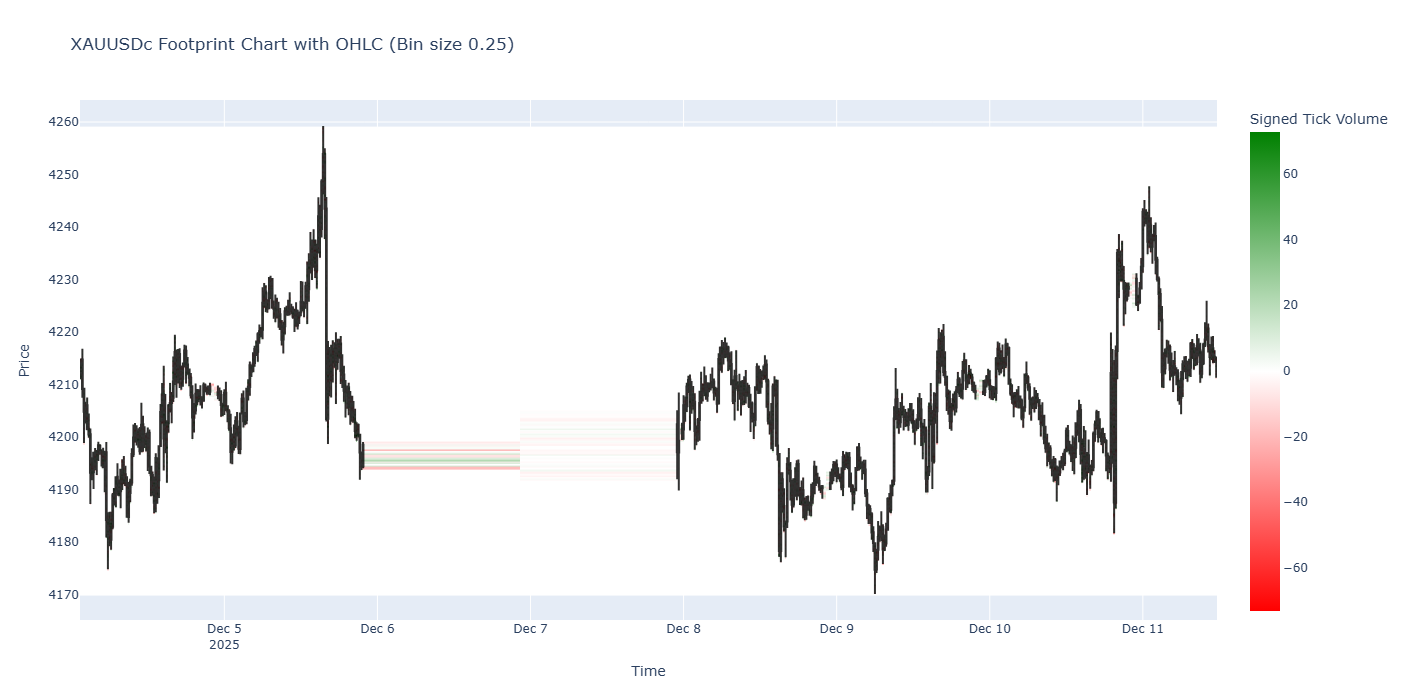

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15  # 1-minute bars
num_bars = 500                # number of bars to fetch
bin_size = 0.25               # price bin size

# -------------------------------
# 2. Fetch data from MT5
# -------------------------------
utc_from = datetime.now() - timedelta(days=5)
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, num_bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Prepare bins for footprint
# -------------------------------
price_min = np.floor(df['low'].min() / bin_size) * bin_size
price_max = np.ceil(df['high'].max() / bin_size) * bin_size
bins = np.arange(price_min, price_max + bin_size, bin_size)
bin_labels = bins[:-1]  # histogram returns len(bins)-1

# Initialize footprint DataFrames
footprint = pd.DataFrame(0, index=df['time'], columns=bin_labels)

# -------------------------------
# 4. Aggregate tick volumes into bins (buy/sell split)
# -------------------------------
for i, row in df.iterrows():
    ticks = int(row['tick_volume'])
    tick_prices = np.random.uniform(row['low'], row['high'], ticks)
    
    # Assign buy (+) or sell (-)
    tick_side = np.random.choice([1, -1], size=ticks, p=[0.5, 0.5])
    tick_values = tick_side  # +1 for buy, -1 for sell

    # Bin the tick prices with signed volumes
    for j, price in enumerate(tick_prices):
        bin_index = np.searchsorted(bin_labels, price, side='right') - 1
        if 0 <= bin_index < len(bin_labels):
            footprint.iloc[i, bin_index] += tick_values[j]

# -------------------------------
# 5. Plot footprint heatmap with OHLC candles
# -------------------------------
fig = go.Figure()

# Footprint heatmap: red <0, green >0
colorscale = [[0.0, 'red'], [0.5, 'white'], [1.0, 'green']]
fig.add_trace(go.Heatmap(
    z=footprint.values.T,
    x=footprint.index,
    y=footprint.columns,
    colorscale=colorscale,
    colorbar=dict(title='Signed Tick Volume'),
    zmid=0
))

# Overlay OHLC candles
fig.add_trace(go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='black',
    decreasing_line_color='black',
    opacity=0.8,
    name='OHLC'
))

fig.update_layout(
    title=f'{symbol} Footprint Chart with OHLC (Bin size {bin_size})',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=700,
    width=1200
)

fig.show()
